<a href="https://colab.research.google.com/github/sebatlab/Antaki2021/blob/main/Antaki2021_R_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Contents
-------------------
* [Variance Explained by Genetic Risk Factors](#variance_explained_by_genetic_risk_factors)
* [Negative Correlations of Rare and Common](#negative_correlations_rare_common)
* [Gene-Phenotype Correlations](#gene_phenotype_correlations)

In [1]:
# Install packages
install.packages("gplots")
install.packages("basicTrendline")

# Attaching packages
library(gplots)
library(basicTrendline)


# Figure 2A packages
install.packages("fmsb")
install.packages("lmtest")
install.packages("boot")
install.packages("stringr")

library(fmsb)
library(lmtest)
library(boot)
library(stringr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘investr’



Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘zoo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [6]:
# Input filenames and output filenames. I should add which sections take in
# which inputs and outputs.

filename_table = "SummaryGeneticData_REACH_SSC_SPARK.SBayesR.20210709.csv"
filename_phen  = "master_phen_4.SBayesR.csv"

r2_out = "R2_estimates.20210709.csv"
responses_out = "SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.20210709.csv"
asd_genetic_correlations_by_sex_out = "asd_genetic_correlations_by_sex_final.SBayesR.20210729.tsv"
clin_results_out = "clin_results_eur.SBayesR.20210709.csv"

<a name="variance_explained_by_genetic_risk_factors"></a>
## Variance Explained by Genetic Risk Factors (Fig. 2A)

In [7]:
# Load table
df <- read.table(filename_table, header = TRUE, sep = ",")
df <- df[df$EUR.Ancestry == 1,] # Only use samples with European ancestry
df <- df[df$Family.Type == "trio",] # Only use trios for this analysis
# Drop SV columns (not used in this analysis)
drops <- c("dnSV",
           "SV.LoF.Paternal.Transmitted","SV.LoF.Paternal.Untransmitted",
          "SV.LoF.Maternal.Transmitted","SV.LoF.Maternal.Untransmitted",
          "CRE.SV.Paternal.Transmitted","CRE.SV.Paternal.Untransmitted",
          "CRE.SV.Maternal.Transmitted","CRE.SV.Maternal.Untransmitted",
          "RVRS","PRS","GRS")
df <- df[ , !(names(df) %in% drops)]
df <- na.omit(df) # Remove rows with NA values

# Make cohort variables
df$REACH_cohort = as.numeric(df$Cohort == "REACH")
df$SPARK_cohort = as.numeric(df$Cohort == "SPARK")
df$SSC_cohort = as.numeric(df$Cohort == "SSC")

dfm <- df[df$Sex == 0,] # Dataframe containing only male samples
dff <- df[df$Sex == 1,] # Dataframe containing only female samples

# Grab PCs
# df[,grep("^PC([1-9]|10)$", names(df), value=TRUE)]
# Grab Sex
# df[,grep("^Sex$", names(df), value=TRUE)]
# Grab Phenotype
# df[,grep("^Phenotype$", names(df), value=TRUE)]

# Sample rows (without replacement by default?)
# df[sample(nrow(df), 1000), ]

In [8]:
# Written by James Guevara

# The bootstrap is used to estimate a confidence interval for the R2 estimates.
# However, the bootstrap procedure seemingly requires a lot of CPUs and takes a lot of time
# given the amount of data in the table.
# So I ran the procedure on a compute cluster (Comet at UCSD) using the Slurm Workload Manager.
# But I've adapted the code here so that the reader can understand how we ran the
# bootstrap. 
getNagelkerkeR2_bootstrap <- function(formula, data, indices) {
  d <- data[indices,]
  fit_alt  <- glm(formula = formula, data = d, family = binomial)
  fit_null <- glm(formula = d$Phenotype~d$Sex+d$PC1+d$PC2+d$PC3+d$PC4+d$PC5+d$PC6+d$PC7+d$PC8+d$PC9+d$PC10+d$REACH_cohort+d$SPARK_cohort+d$SSC_cohort, data=d, family=binomial)
  return(NagelkerkeR2(fit_alt)$R2 - NagelkerkeR2(fit_null)$R2)
}

getNagelkerkeR2 <- function(dataframe, alt_vars_in, null_vars_in, text) {
  d <- dataframe
  alt_variables <- alt_vars_in
  alt_formula <- reformulate(alt_variables, response = "Phenotype")
  null_variables <- null_vars_in
  null_formula <- reformulate(null_variables, response = "Phenotype")
  fit_alt  <- glm(formula = alt_formula , data = d, family = binomial)
  fit_null <- glm(formula = null_formula , data = d, family = binomial)
  nagelkerke_R2_val = NagelkerkeR2(fit_alt)$R2 - NagelkerkeR2(fit_null)$R2
  lr <- lrtest(fit_alt,fit_null) # Likelihood ratio test
  lr_p_val = lr["Pr(>Chisq)"][2,1] # p-value

  # cat(c(text,"\n"))
  # cat(c("R2:\t", nagelkerke_R2_val, "\t", "Likelihood_ratio_test_p-value:\t", lr_p_val, "\n"))

  # Put into dataframe? (R2, p-value)
  df_r2 = data.frame(text, nagelkerke_R2_val, lr_p_val)

  # Get the alt_vars_in c vector into a format appropriate for the bootstrap function 
  alt_vars_formula = paste(unlist(strsplit(alt_vars_in, split="d$", fixed=TRUE)), collapse=" ")
  alt_vars_formula = paste("Phenotype ~", alt_vars_formula, collapse= " ")
  # print(alt_vars_formula)

  # Using the bootstrap to get the confidence interval estimates (and standard error of R2)
  # r2_stats <- boot(data=d, statistic=getNagelkerkeR2_bootstrap, R=10000, formula=alt_vars_formula, parallel="multicore", ncpus=2)
  # ste = sd(r2_stats$t)
  # ci = boot.ci(r2_stats, type="bca") # Using the BCa interval (more information here: https://blogs.sas.com/content/iml/2017/07/12/bootstrap-bca-interval.html)
  # ci_lower = as.double(ci$bca[1,4])
  # ci_upper = as.double(ci$bca[1,5])
  # df_r2_tmp = data.frame(text, nagelkerke_R2_val, lr_p_val, ste, ci_lower, ci_upper)


  return(df_r2)
} 


cohort_vars <- c("d$REACH_cohort+d$SPARK_cohort+d$SSC_cohort")

pc_vars <- c("d$PC1+d$PC2+d$PC3+d$PC4+d$PC5+d$PC6+d$PC7+d$PC8+d$PC9+d$PC10")
sex_var <- c("d$Sex") # Only use with combined models (it doesn't matter)
# null_vars <- paste(pc_vars, sex_var, sep = "+") 
null_vars <- paste(cohort_vars, pc_vars, sex_var, sep = "+") 


# Full model
var <- c("d$dnMIS+d$dnLOF+d$inhLoF+d$pTDT.ASD.Dev+d$pTDT.EA.Dev+d$pTDT.SCZ.Dev")
alt_vars  <- paste(var, cohort_vars, pc_vars, sex_var, sep = "+")
df_full_r2 = getNagelkerkeR2(df, alt_vars, null_vars, "combined_both")
# Males
df_full_r2_male = getNagelkerkeR2(dfm, alt_vars, null_vars, "combined_male")
# Females
df_full_r2_female = getNagelkerkeR2(dff, alt_vars, null_vars, "combined_female")


# PRS model
var <- c("d$pTDT.ASD.Dev+d$pTDT.EA.Dev+d$pTDT.SCZ.Dev")
alt_vars  <- paste(var, cohort_vars, pc_vars, sex_var, sep = "+")
df_prs_r2 = getNagelkerkeR2(df, alt_vars, null_vars, "prs_both")
# Males
df_prs_r2_male = getNagelkerkeR2(dfm, alt_vars, null_vars, "prs_male")
# Females
df_prs_r2_female = getNagelkerkeR2(dff, alt_vars, null_vars, "prs_female")

# Rare model
var <- c("d$dnMIS+d$dnLOF+d$inhLoF")
alt_vars  <- paste(var, cohort_vars, pc_vars, sex_var, sep = "+")
df_rare_r2 = getNagelkerkeR2(df, alt_vars, null_vars, "rare_both")
# Males
df_rare_r2_male = getNagelkerkeR2(dfm, alt_vars, null_vars, "rare_male")
# Females
df_rare_r2_female = getNagelkerkeR2(dff, alt_vars, null_vars, "rare_female")

# pTDT.ASD.Dev
var <- c("d$pTDT.ASD.Dev")
alt_vars  <- paste(var, cohort_vars, pc_vars, sex_var, sep = "+")
df_ptdt_asd_r2 = getNagelkerkeR2(df, alt_vars, null_vars, "ptdt.asd.dev_both")
# Males
df_ptdt_asd_r2_male = getNagelkerkeR2(dfm, alt_vars, null_vars, "ptdt.asd.dev_male")
# Females
df_ptdt_asd_r2_female = getNagelkerkeR2(dff, alt_vars, null_vars, "ptdt.asd.dev_female")

# pTDT.EA.Dev
var <- c("d$pTDT.EA.Dev")
alt_vars  <- paste(var, cohort_vars, pc_vars, sex_var, sep = "+")
df_ptdt_ea_r2 = getNagelkerkeR2(df, alt_vars, null_vars, "ptdt.ea.dev_both")
# Males
df_ptdt_ea_r2_male =getNagelkerkeR2(dfm, alt_vars, null_vars, "ptdt.ea.dev_male")
# Females
df_ptdt_ea_r2_female = getNagelkerkeR2(dff, alt_vars, null_vars, "ptdt.ea.dev_female")

# pTDT.SCZ.Dev
var <- c("d$pTDT.SCZ.Dev")
alt_vars  <- paste(var, cohort_vars, pc_vars, sex_var, sep = "+")
df_ptdt_scz_r2 = getNagelkerkeR2(df, alt_vars, null_vars, "ptdt.scz.dev_both")
# Males
df_ptdt_scz_r2_male = getNagelkerkeR2(dfm, alt_vars, null_vars, "ptdt.scz.dev_male")
# Females
df_ptdt_scz_r2_female = getNagelkerkeR2(dff, alt_vars, null_vars, "ptdt.scz.dev_female")

# dnMIS
var <- c("d$dnMIS")
alt_vars  <- paste(var, cohort_vars, pc_vars, sex_var, sep = "+")
df_dnmis_r2 = getNagelkerkeR2(df, alt_vars, null_vars, "dnMIS_both")
# Males
df_dnmis_r2_male = getNagelkerkeR2(dfm, alt_vars, null_vars, "dnMIS_male")
# Females
df_dnmis_r2_female = getNagelkerkeR2(dff, alt_vars, null_vars, "dnMIS_female")

# dnLOF
var <- c("d$dnLOF")
alt_vars  <- paste(var, cohort_vars, pc_vars, sex_var, sep = "+")
df_dnlof_r2 = getNagelkerkeR2(df, alt_vars, null_vars, "dnLOF_both")
# Males
df_dnlof_r2_male = getNagelkerkeR2(dfm, alt_vars, null_vars, "dnLOF_male")
# Females
df_dnlof_r2_female = getNagelkerkeR2(dff, alt_vars, null_vars, "dnLOF_female")

# inhLoF
var <- c("d$inhLoF")
alt_vars  <- paste(var, cohort_vars, pc_vars, sex_var, sep = "+")
df_inhlof_r2 = getNagelkerkeR2(df, alt_vars, null_vars, "inhLOF_both")
# Males
df_inhlof_r2_male = getNagelkerkeR2(dfm, alt_vars, null_vars, "inhLOF_male")
# Females
df_inhlof_r2_female = getNagelkerkeR2(dff, alt_vars, null_vars, "inhLOF_female")


# Combine all the dataframes
df_combined = rbind(df_full_r2, df_full_r2_male, df_full_r2_female,
                    df_prs_r2, df_prs_r2_male, df_prs_r2_female,
                    df_rare_r2, df_rare_r2_male, df_rare_r2_female,
                    df_ptdt_asd_r2, df_ptdt_asd_r2_male, df_ptdt_asd_r2_female,
                    df_ptdt_ea_r2, df_ptdt_ea_r2_male, df_ptdt_ea_r2_female,
                    df_ptdt_scz_r2, df_ptdt_scz_r2_male, df_ptdt_scz_r2_female,
                    df_dnmis_r2, df_dnmis_r2_male, df_dnmis_r2_female,
                    df_dnlof_r2, df_dnlof_r2_male, df_dnlof_r2_female,
                    df_inhlof_r2, df_inhlof_r2_male, df_inhlof_r2_female)

# Add a header to the combined dataframe
colnames(df_combined) <- c("R2_type", "R2", "Likelihood_Ratio_p_value")

# Write to file
write.csv(df_combined, file=r2_out, row.name=TRUE)

In [9]:
# Responses from residuals
library(fmsb)
options(stringsAsFactors = FALSE);

d = df

# PRS scores residualized:
ptdt_prs_asd_resid <- resid(glm(d$pTDT.ASD.Dev~d$PC1+d$PC2+d$PC3+d$PC4+d$PC5+d$PC6+d$PC7+d$PC8+d$PC9+d$PC10+d$REACH_cohort+d$SPARK_cohort+d$SSC_cohort+d$Sex, data=d, na.action="na.exclude"))
ptdt_prs_ea_resid  <- resid(glm(d$pTDT.EA.Dev  ~d$PC1+d$PC2+d$PC3+d$PC4+d$PC5+d$PC6+d$PC7+d$PC8+d$PC9+d$PC10+d$REACH_cohort+d$SPARK_cohort+d$SSC_cohort+d$Sex, data=d, na.action="na.exclude"))
ptdt_prs_scz_resid <- resid(glm(d$pTDT.SCZ.Dev~d$PC1+d$PC2+d$PC3+d$PC4+d$PC5+d$PC6+d$PC7+d$PC8+d$PC9+d$PC10+d$REACH_cohort+d$SPARK_cohort+d$SSC_cohort+d$Sex, data=d, na.action="na.exclude"))


# Fit combined prs model
fit_alt_prs <- glm(d$Phenotype~ptdt_prs_asd_resid+ptdt_prs_ea_resid+ptdt_prs_scz_resid, data=df, family=binomial)
response_prs = predict(fit_alt_prs, type = "response")

# Rare scores residualized
snv_dn_lof_resid <- resid(glm(d$dnLOF ~d$PC1+d$PC2+d$PC3+d$PC4+d$PC5+d$PC6+d$PC7+d$PC8+d$PC9+d$PC10+d$REACH_cohort+d$SPARK_cohort+d$SSC_cohort+d$Sex, data=d,na.action="na.exclude"))
snv_dn_mis_resid <- resid(glm(d$dnMIS ~d$PC1+d$PC2+d$PC3+d$PC4+d$PC5+d$PC6+d$PC7+d$PC8+d$PC9+d$PC10+d$REACH_cohort+d$SPARK_cohort+d$SSC_cohort+d$Sex, data=d,na.action="na.exclude") )
snv_lof_t_resid  <- resid(glm(d$inhLoF~d$PC1+d$PC2+d$PC3+d$PC4+d$PC5+d$PC6+d$PC7+d$PC8+d$PC9+d$PC10+d$REACH_cohort+d$SPARK_cohort+d$SSC_cohort+d$Sex, data=d,na.action="na.exclude") )


# Fit combined rare model
fit_alt_rare <- glm(d$Phenotype~snv_dn_lof_resid+snv_dn_mis_resid+snv_lof_t_resid, data=d, family=binomial)
response_rare = predict(fit_alt_rare, type = "response")

# Fit rare + prs combined model
fit_alt_combined <- glm(d$Phenotype~ptdt_prs_asd_resid+ptdt_prs_ea_resid+ptdt_prs_scz_resid+snv_dn_lof_resid+snv_dn_mis_resid+snv_lof_t_resid, data=d, family=binomial)
response_combined = predict(fit_alt_combined, type = "response")

# Fit individual features
# ptdt_prs_asd
fit_alt_ptdt_prs_asd <- glm(d$Phenotype~ptdt_prs_asd_resid, data=d, family=binomial)
response_ptdt_prs_asd = predict(fit_alt_ptdt_prs_asd, type = "response")
# ptdt_prs_ea
fit_alt_ptdt_prs_ea <- glm(d$Phenotype~ptdt_prs_ea_resid, data=d, family=binomial)
response_ptdt_prs_ea = predict(fit_alt_ptdt_prs_ea, type = "response")
# ptdt_prs_scz
fit_alt_ptdt_prs_scz <- glm(d$Phenotype~ptdt_prs_scz_resid, data=d, family=binomial)
response_ptdt_prs_scz = predict(fit_alt_ptdt_prs_scz, type = "response")

# snv_dn_lof
fit_alt_snv_dn_lof <- glm(d$Phenotype~snv_dn_lof_resid, data=d, family=binomial)
response_snv_dn_lof = predict(fit_alt_snv_dn_lof, type = "response")
# snv_dn_mis
fit_alt_snv_dn_mis <- glm(d$Phenotype~snv_dn_mis_resid, data=d, family=binomial)
response_snv_dn_mis = predict(fit_alt_snv_dn_mis, type = "response")
# snv_lof_t
fit_alt_snv_lof_t <- glm(d$Phenotype~snv_lof_t_resid, data=d, family=binomial)
response_snv_lof_t = predict(fit_alt_snv_lof_t, type = "response")

# Responses (not z-scored yet)
# d$all_combined_score = response_combined
# d$prs_combined_score = response_prs
# d$rare_combined_score = response_rare
# d$response_ptdt_prs_asd = response_ptdt_prs_asd
# d$response_ptdt_prs_asd = response_ptdt_prs_ea
# d$response_ptdt_prs_scz = response_ptdt_prs_scz
# d$response_snv_dn_lof = response_snv_dn_lof
# d$response_snv_dn_mis = response_snv_dn_mis
# d$response_snv_lof_t = response_snv_lof_t

# Get GRS, PRS, RVRS columns (normalize all_combined_score, prs_combined_score, and rare_combined_score)
d$GRS = (response_combined - mean(response_combined))/sd(response_combined)
d$PRS = (response_prs - mean(response_prs))/sd(response_prs)
d$RVRS = (response_rare - mean(response_rare))/sd(response_rare)

write.csv(d, file=responses_out, row.name=TRUE)

<a name="negative_correlations_rare_common"></a>
## Negative correlations of rare and common (Fig. 3)
-------------------------------

In [10]:
# Written by Danny Antaki, edited by James Guevara
options(stringsAsFactors = FALSE);
# df = read.csv("SummaryGeneticData_REACH_SSC_SPARK.csv",sep=",")
df = read.csv("SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.20210709.csv",sep=",")
df$dnAll = df$dnLOF+df$dnMIS
df$cohort_covar <- factor(df$Cohort)
df <- df[df$EUR.Ancestry==1,]
vars<-c(
    "dnMIS" ,"dnLOF","dnAll",
    "inhLoF", "RVRS" , 
    "pTDT.ASD.Dev" , "pTDT.SCZ.Dev" ,"pTDT.EA.Dev",
    "PRS"
);
cols <- c("cohort_covar","Sex","Phenotype","PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10",vars)
df<-na.omit(df[cols])
print(nrow(df))
###########################################
fit_model<- function(df,x,y,add_sex=FALSE){
    Y<- df[[x]]
    X<- df[[y]]
    PC1<-df$PC1
    PC2<-df$PC2
    PC3<-df$PC3
    PC4<-df$PC4
    PC5<-df$PC5
    PC6<-df$PC6
    PC7<-df$PC7
    PC8<-df$PC8
    PC9<-df$PC9
    PC10<-df$PC10
    phen<-df$Phenotype
    cohort_covar<-df$cohort_covar
    sex<-df$Sex
    sex_pv<-NA    
    if (add_sex==TRUE){
        mod<-lm(Y~X+sex+phen+cohort_covar+PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10)
        nul<-lm(Y~sex+phen+cohort_covar+PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10)
        #sex interaction
        interaction_mod<-lm(Y~X*sex+phen+cohort_covar+PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10)
        sex_pv<-signif(summary(interaction_mod)$coefficients[17,4],digits=2)
    } else {
        mod<-lm(Y~X+phen+cohort_covar+PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10)
        nul<-lm(Y~phen+cohort_covar+PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10)
    }
    # slope of fit of X to Y
    est<-signif(summary(mod)$coefficients[2,1],digits=2)
    xpv<-signif(summary(mod)$coefficients[2,4],digits=2)
    #r2 is the difference of the mod with X and without X
    r2<-signif(summary(mod)$r.squared-summary(nul)$r.squared,digits=2)
    pearsons_cor<-signif(cor(Y,X, use="pairwise.complete.obs"),digits=2)    
    if (add_sex==TRUE){
        result = paste(est,xpv,r2,pearsons_cor,sex_pv,sep="\t")
    } else {
        result = paste(est,xpv,r2,pearsons_cor,sep="\t")
    }
    #sprintf("%f\t%f\t%f\t%f\t%f",est,xpv,r2,pearson_cor,sex_pv)
    return(result)
}
###########################################
header = paste("y","x",
               "male_est","male_pval","male_r2","male_cor",
               "female_est","female_pval","female_r2","female_cor",
               "combined_est","combined_pval","combined_r2","combined_cor",
               "sex_interaction_pval",
               sep="\t"
              );
output=vector(length = 1+(length(vars)^2)-(length(vars)))
output[1]<-header
i=2
for (x in vars)
{
  for(y in vars)
  {
    if (x==y){ next; } 
    com_results <- fit_model(df,x,y,add_sex=TRUE)
    mal_results <- fit_model(df[df$Sex==0,],x,y,add_sex=FALSE)
    fem_results <- fit_model(df[df$Sex==1,],x,y,add_sex=FALSE)
    # Y - X - mal
    output[i] <- paste(x,y,mal_results,fem_results,com_results,sep="\t")
    i=i+1;
  }
}
out = asd_genetic_correlations_by_sex_out
ofh<-file(out)
writeLines(output,ofh)
close(ofh)
print(">>>DONE<<<")

[1] 8301
[1] ">>>DONE<<<"


<a name="gene_phenotype_correlations"></a>
## Gene–phenotype correlations (Fig. 5)

In [11]:
#Author: Jonathan Sebat http://sebatlab.org March 19, 2021

#The following phenotypes were available for only one cohort in either cases or controls: srs.case,vabs.case,srs.cont,scq.cont,vabs.cont,bapq.parents,srs.parents)
#for these, age, sex and PCs were included as covariates, but not cohort (a 1st set of functions is written for this test)

#SCQ, RBS and DCDQ were available on cases in the multiple cohorts (SSC and SPARK). Parental age and educational attainment were also available on multiple cohorts
#for these, "cohort" was included as a covariate (a 2nd set of functions are written for this test)



#importing the input data table that contains rare variant counts (dnLoF, dnMis, inhLoF), polygenic scores(PSasd, PSsz, PSea) and clinical phenotypes (srs, scq, rbs, vabs, dcdq, parental age, parental educational attainment, parental bapq)

# master.gen.phen.table<-read.csv("C:\\Users\\jsebat\\sebatlab Dropbox\\Autism\\Autism_Illumina_WGS\\RV_PRS_Analysis_Jun2020\\master_phen_4.csv", header = TRUE)
master.gen.phen.table<-read.csv(filename_phen, header = TRUE)


################################################################################
##################################################################################
####### First we create the main functions to run linear regression   ###########
#######        on y = phenoype, x = genetic factor                    #############
#####################################################################################
#####################################################################################

###############    1st set of scripts ###########################################################3
#For phenotypes available on only a single cohort, "cohort" is NOT included as a covariate
#linear regression controls for age, sex and PCs
#and tests for a gene-by-sex interactions
#the functions for these are as follows
#gen.phen.1 a function that runs a linear regression and tests for gene-by-sex interaction. These are the primary results described in Fig. 5
#gen.phen.2 To characterize gene-by sex effects that are significant, gene.phen.2 runs the regression on males and females separately without sex as a covariate
#gene.phen.3 runs linear regression and gene-by-sex interaction on PARENTS, then to investigate gene by sex interactions, runs regression on mothers and fathers individually


#gen.phen.1 a function that runs a linear regression on both sexes and outputs the result

gen.phen.1<-function(master.temp,phen.col,age.col)
{
#define the sexes
male<-master.temp$sex=="Male"
female<-master.temp$sex=="Female"
  
#Test combined sample
sex<-master.temp$sex
cohort<-master.temp$cohort
PC1<-master.temp$PC1
PC2<-master.temp$PC2
PC3<-master.temp$PC3
PC4<-master.temp$PC4
PC5<-master.temp$PC5
PC6<-master.temp$PC6
PC7<-master.temp$PC7
PC8<-master.temp$PC8
PC9<-master.temp$PC9
PC10<-master.temp$PC10

#retreive phen data
y<-master.temp[,phen.col]
age<-master.temp[,age.col]


#retreive gen data
x.dnlof<-master.temp[,"dnLoF"]
x.dn<-master.temp[,"dnMIS"]
x.inh<-master.temp[,"inhLoF"]
x.ps.asd<-master.temp[,"PS.ASD.Z"]
x.ps.sz<-master.temp[,"PS.SZ.Z"]
x.ps.ea<-master.temp[,"PS.EA.Z"]

result.dnlof<-lr.1(y,x.dnlof,sex,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
result.dn<-lr.1(y,x.dn,sex,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
result.inh<-lr.1(y,x.inh,sex,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
result.ps.asd<-lr.1(y,x.ps.asd,sex,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
result.ps.sz<-lr.1(y,x.ps.sz,sex,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
result.ps.ea<-lr.1(y,x.ps.ea,sex,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)

comb.result<-rbind(result.dnlof,result.dn,result.inh,result.ps.asd,result.ps.sz,result.ps.ea)
variant.type<-c("dnlof","dnmis","inhLoF", "ps.asd","ps.sz","ps.ea")
group<-rep("combined",length(variant.type))
comb.result<-cbind(group,variant.type,comb.result)

#################Test males

PC1<-master.temp$PC1[male]
PC2<-master.temp$PC2[male]
PC3<-master.temp$PC3[male]
PC4<-master.temp$PC4[male]
PC5<-master.temp$PC5[male]
PC6<-master.temp$PC6[male]
PC7<-master.temp$PC7[male]
PC8<-master.temp$PC8[male]
PC9<-master.temp$PC9[male]
PC10<-master.temp$PC10[male]

#retreive phen data
y<-master.temp[male,phen.col]
age<-master.temp[male,age.col]


#retreive gen data
x.dnlof<-master.temp[male,"dnLoF"]
x.dn<-master.temp[male,"dnMIS"]
x.inh<-master.temp[male,"inhLoF"]
x.ps.asd<-master.temp[male,"PS.ASD.Z"]
x.ps.sz<-master.temp[male,"PS.SZ.Z"]
x.ps.ea<-master.temp[male,"PS.EA.Z"]


result.dnlof<-lr.2(y,x.dnlof,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
result.dn<-lr.2(y,x.dn,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
result.inh<-lr.2(y,x.inh,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
result.ps.asd<-lr.2(y,x.ps.asd,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
result.ps.sz<-lr.2(y,x.ps.sz,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
result.ps.ea<-lr.2(y,x.ps.ea,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)

male.result<-rbind(result.dnlof,result.dn,result.inh,result.ps.asd,result.ps.sz,result.ps.ea)
variant.type<-c("dnlof","dnmis","inhLoF", "ps.asd","ps.sz","ps.ea")
group<-rep("male",length(variant.type))
male.result<-cbind(group,variant.type,male.result)

#####Test females ######################

PC1<-master.temp$PC1[female]
PC2<-master.temp$PC2[female]
PC3<-master.temp$PC3[female]
PC4<-master.temp$PC4[female]
PC5<-master.temp$PC5[female]
PC6<-master.temp$PC6[female]
PC7<-master.temp$PC7[female]
PC8<-master.temp$PC8[female]
PC9<-master.temp$PC9[female]
PC10<-master.temp$PC10[female]

#retreive phen data
y<-master.temp[female,phen.col]
age<-master.temp[female,age.col]


#retreive gen data
x.dnlof<-master.temp[female,"dnLoF"]
x.dn<-master.temp[female,"dnMIS"]
x.inh<-master.temp[female,"inhLoF"]
x.ps.asd<-master.temp[female,"PS.ASD.Z"]
x.ps.sz<-master.temp[female,"PS.SZ.Z"]
x.ps.ea<-master.temp[female,"PS.EA.Z"]


result.dnlof<-lr.2(y,x.dnlof,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
result.dn<-lr.2(y,x.dn,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
result.inh<-lr.2(y,x.inh,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
result.ps.asd<-lr.2(y,x.ps.asd,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
result.ps.sz<-lr.2(y,x.ps.sz,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
result.ps.ea<-lr.2(y,x.ps.ea,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)

female.result<-rbind(result.dnlof,result.dn,result.inh,result.ps.asd,result.ps.sz,result.ps.ea)
variant.type<-c("dnlof","dnmis","inhLoF", "ps.asd","ps.sz","ps.ea")
group<-rep("female",length(variant.type))
female.result<-cbind(group,variant.type,female.result)

final.result<-rbind(female.result,male.result,comb.result)
final.result
}


#linear regression script 1 that also tests sex interaction
lr.1<-function(y,x,sex,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
{
  model<-lm(y~x+sex+age+PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10)
  n.model<-lm(y~sex+age+PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10)
  est<-signif(summary(model)$coefficients[2,1],digits=2)
  est.stderr<-signif(summary(model)$coefficients[2,2],digits=2)
  x.pval<-signif(summary(model)$coefficients[2,4],digits=2)
  r.sq<-signif(summary(model)$r.squared-summary(n.model)$r.squared,digits=2)
  pearson.cor<-cor.test(x,y)
  pearson.cc<-pearson.cor$estimate

  
  #test sex interaction
  int.model<-lm(y~x*sex+age+PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10)
  sex.pval<-signif(summary(int.model)$coefficients[15,4],digits=2)
  
  result<-cbind(r.sq,est,est.stderr,pearson.cc,x.pval,sex.pval)
  result
}

###############################################################################33
#Then we have a function that doesn't test the sex interaction
##############################################################################

gen.phen.2<-function(master.temp,phen.col,age.col)
{
  #retrieve covariates
  PC1<-master.temp$PC1
  PC2<-master.temp$PC2
  PC3<-master.temp$PC3
  PC4<-master.temp$PC4
  PC5<-master.temp$PC5
  PC6<-master.temp$PC6
  PC7<-master.temp$PC7
  PC8<-master.temp$PC8
  PC9<-master.temp$PC9
  PC10<-master.temp$PC10
  
  #retreive phen data
  y<-master.temp[,phen.col]
  age<-master.temp[,age.col]
  
  #retreive gen data
  x.dnlof<-master.temp[,"dnLoF"]
  x.dn<-master.temp[,"dnMIS"]
  x.inh<-master.temp[,"inhLoF"]
  x.ps.asd<-master.temp[,"PS.ASD.Z"]
  x.ps.sz<-master.temp[,"PS.SZ.Z"]
  x.ps.ea<-master.temp[,"PS.EA.Z"]

  
  result.dnlof<-lr.2(y,x.dnlof,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.dn<-lr.2(y,x.dn,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.inh<-lr.2(y,x.inh,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.ps.asd<-lr.2(y,x.ps.asd,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.ps.sz<-lr.2(y,x.ps.sz,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.ps.ea<-lr.2(y,x.ps.ea,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  
  final.result<-rbind(result.dnlof,result.dn,result.inh,result.ps.asd,result.ps.sz,result.ps.ea)
  variant.type<-c("dnlof","dnmis","inhLoF", "ps.asd","ps.sz","ps.ea")
  final.result<-cbind(variant.type,final.result)
  final.result
}



#linear regression script 2 for testing each sex individually
lr.2<-function(y,x,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
{
  model<-lm(y~x+age+PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10)
  n.model<-lm(y~age+PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10)
  est<-signif(summary(model)$coefficients[2,1],digits=2)
  est.stderr<-signif(summary(model)$coefficients[2,2],digits=2)
  x.pval<-signif(summary(model)$coefficients[2,4],digits=2)
  r.sq<-signif(summary(model)$r.squared-summary(n.model)$r.squared,digits=2)
  pearson.cor<-cor.test(x,y)
  pearson.cc<-pearson.cor$estimate
  
  #test sex interaction
  sex.pval<-NA
  result<-cbind(r.sq,est,est.stderr,pearson.cc,x.pval,sex.pval)
  result
}
##################################################################
# Then we have a regression for testing the effects of parents
#################################################################

#Ftests phenotypes in parents and tests sex interaction
gen.phen.3<-function(master.temp,phen.col.f,phen.col.m)
{
  #retrieve father data
  ###########################
  sexfather<-rep(1,nrow(master.temp))
  PC1f<-master.temp$PC1_PAT
  PC2f<-master.temp$PC2_PAT
  PC3f<-master.temp$PC3_PAT
  PC4f<-master.temp$PC4_PAT
  PC5f<-master.temp$PC5_PAT
  PC6f<-master.temp$PC6_PAT
  PC7f<-master.temp$PC7_PAT
  PC8f<-master.temp$PC8_PAT
  PC9f<-master.temp$PC9_PAT
  PC10f<-master.temp$PC10_PAT
  
  #retreive phen data
  yf<-master.temp[,phen.col.f]
  
  
  #retreive gen data
  f.dnlof<-master.temp[,"dnLoF"]
  f.dn<-master.temp[,"dnMIS"]
  f.inh<-master.temp$InhLoF.Paternal.Transmitted + master.temp$InhLoF.Paternal.Untransmitted
  f.ps.asd<-master.temp$Paternal.PS.ASD.Z
  f.ps.sz<-master.temp$Paternal.PS.SZ.Z
  f.ps.ea<-master.temp$Paternal.PS.EA.Z
  
  #retrieve mother data
  ###########################
  
  sexmother<-rep(0,nrow(master.temp))
  PC1m<-master.temp$PC1_MAT
  PC2m<-master.temp$PC2_MAT
  PC3m<-master.temp$PC3_MAT
  PC4m<-master.temp$PC4_MAT
  PC5m<-master.temp$PC5_MAT
  PC6m<-master.temp$PC6_MAT
  PC7m<-master.temp$PC7_MAT
  PC8m<-master.temp$PC8_MAT
  PC9m<-master.temp$PC9_MAT
  PC10m<-master.temp$PC10_MAT
  
  #retreive phen data
  ym<-master.temp[,phen.col.m]
  
  #retreive gen data
  m.dnlof<-master.temp[,"dnLoF"]
  m.dn<-master.temp[,"dnMIS"]
  m.inh<-master.temp$InhLoF.Maternal.Transmitted + master.temp$InhLoF.Maternal.Untransmitted
  m.ps.asd<-master.temp$Maternal.PS.ASD.Z
  m.ps.sz<-master.temp$Maternal.PS.SZ.Z
  m.ps.ea<-master.temp$Maternal.PS.EA.Z
  
  #merge father and mother variables
  sex<-c(sexfather,sexmother)
  PC1<-c(PC1f,PC1m)
  PC2<-c(PC2f,PC2m)
  PC3<-c(PC3f,PC3m)
  PC4<-c(PC4f,PC4m)
  PC5<-c(PC5f,PC5m)
  PC6<-c(PC6f,PC6m)
  PC7<-c(PC7f,PC7m)
  PC8<-c(PC8f,PC8m)
  PC9<-c(PC9f,PC9m)
  PC10<-c(PC10f,PC10m)
  x.dnlof<-c(f.dnlof,m.dnlof)
  x.dn<-c(f.dn,m.dn)
  x.inh<-c(f.inh,m.inh)
  x.ps.asd<-c(f.ps.asd,m.ps.asd)
  x.ps.sz<-c(f.ps.sz,m.ps.sz)
  x.ps.ea<-c(f.ps.ea,m.ps.ea)
  y<-c(yf,ym)
  
  result.dnlof<-lr.3(y,x.dnlof,sex,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.dn<-lr.3(y,x.dn,sex,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.inh<-lr.3(y, x.inh, sex, PC1, PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.ps.asd<-lr.3(y,x.ps.asd,sex,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.ps.sz<-lr.3(y,x.ps.sz,sex,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.ps.ea<-lr.3(y,x.ps.ea,sex,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  
  #combined result
  comb.result<-rbind(result.dnlof,result.dn,result.inh,result.ps.asd,result.ps.sz,result.ps.ea)
  variant.type<-c("dnlof","dnmis","inhLoF", "ps.asd","ps.sz","ps.ea")
  group<-rep("parents",length=length(variant.type))
  comb.result<-cbind(group,variant.type,comb.result)
  
  
  #father result
  result.dnlof<-lr.4(yf,f.dnlof,PC1f,PC2f,PC3f,PC4f,PC5f,PC6f,PC7f,PC8f,PC9f,PC10f)
  result.dn<-lr.4(yf,f.dn,PC1f,PC2f,PC3f,PC4f,PC5f,PC6f,PC7f,PC8f,PC9f,PC10f)
  result.inh<-lr.4(yf, f.inh, PC1f,PC2f,PC3f,PC4f,PC5f,PC6f,PC7f,PC8f,PC9f,PC10f)
  result.ps.asd<-lr.4(yf,f.ps.asd,PC1f,PC2f,PC3f,PC4f,PC5f,PC6f,PC7f,PC8f,PC9f,PC10f)
  result.ps.sz<-lr.4(yf,f.ps.sz,PC1f,PC2f,PC3f,PC4f,PC5f,PC6f,PC7f,PC8f,PC9f,PC10f)
  result.ps.ea<-lr.4(yf,f.ps.ea,PC1f,PC2f,PC3f,PC4f,PC5f,PC6f,PC7f,PC8f,PC9f,PC10f)
  
  f.result<-rbind(result.dnlof,result.dn,result.inh,result.ps.asd,result.ps.sz,result.ps.ea)
  variant.type<-c("dnlof","dnmis","inhLoF", "ps.asd","ps.sz","ps.ea")
  group<-rep("father",length=length(variant.type))
  f.result<-cbind(group,variant.type,f.result)
  
  #mother result
  result.dnlof<-lr.4(ym,m.dnlof,PC1m,PC2m,PC3m,PC4m,PC5m,PC6m,PC7m,PC8m,PC9m,PC10m)
  result.dn<-lr.4(ym,m.dn,PC1m,PC2m,PC3m,PC4m,PC5m,PC6m,PC7m,PC8m,PC9m,PC10m)
  result.inh<-lr.4(ym, m.inh, PC1m,PC2m,PC3m,PC4m,PC5m,PC6m,PC7m,PC8m,PC9m,PC10m)
  result.ps.asd<-lr.4(ym,m.ps.asd,PC1m,PC2m,PC3m,PC4m,PC5m,PC6m,PC7m,PC8m,PC9m,PC10m)
  result.ps.sz<-lr.4(ym,m.ps.sz,PC1m,PC2m,PC3m,PC4m,PC5m,PC6m,PC7m,PC8m,PC9m,PC10m)
  result.ps.ea<-lr.4(ym,m.ps.ea,PC1m,PC2m,PC3m,PC4m,PC5m,PC6m,PC7m,PC8m,PC9m,PC10m)
  
  m.result<-rbind(result.dnlof,result.dn,result.inh,result.ps.asd,result.ps.sz,result.ps.ea)
  variant.type<-c("dnlof","dnmis","inhLoF", "ps.asd","ps.sz","ps.ea")
  group<-rep("mother",length=length(variant.type))
  m.result<-cbind(group,variant.type,m.result)
  
  #output final result
  final.result<-rbind(m.result,f.result,comb.result)
  final.result
}


#linear regression script 3 tests phenotypes in parents and tests sex interaction
lr.3<-function(y,x,sex,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
{
  model<-lm(y~x+sex+PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10)
  n.model<-lm(y~sex+PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10)
  est<-signif(summary(model)$coefficients[2,1],digits=2)
  est.stderr<-signif(summary(model)$coefficients[2,2],digits=2)
  x.pval<-signif(summary(model)$coefficients[2,4],digits=2)
  r.sq<-signif(summary(model)$r.squared-summary(n.model)$r.squared,digits=2)
  pearson.cor<-cor.test(x,y)
  pearson.cc<-pearson.cor$estimate
  
  #test sex interaction
  int.model<-lm(y~x*sex+PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10)
  sex.pval<-signif(summary(int.model)$coefficients[14,4],digits=2)
  
  result<-cbind(r.sq,est,est.stderr,pearson.cc,x.pval,sex.pval)
  result
}

#linear regression script 4 tests phenotypes in mother or father without sex variable
lr.4<-function(y,x,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
{
  model<-lm(y~x+PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10)
  n.model<-lm(y~PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10)
  est<-signif(summary(model)$coefficients[2,1],digits=2)
  est.stderr<-signif(summary(model)$coefficients[2,2],digits=2)
  x.pval<-signif(summary(model)$coefficients[2,4],digits=2)
  r.sq<-signif(summary(model)$r.squared-summary(n.model)$r.squared,digits=2)
  pearson.cc<-cor(x,y)

  
  #test sex interaction
  sex.pval<-NA
  
  result<-cbind(r.sq,est,est.stderr,pearson.cc,x.pval,sex.pval)
  result
}

#############################     2nd set of scripts with cohort included as a covaraite    ##################
#in addition to age, sex and PCs
#and tests for a gene-by-sex interactions
#the functions for these are as follows
#gen.phen.1c a function that runs a linear regression and tests for gene-by-sex interaction. These are the primary results described in Fig. 5
#gen.phen.2c To characterize gene-by sex effects that are significant, gene.phen.2 runs the regression on males and females separately without sex as a covariate
#gene.phen.3c runs linear regression and gene-by-sex interaction on PARENTS, then to investigate gene by sex interactions, runs regression on mothers and fathers individually


#gen.phen.1c a function that runs a linear regression on both sexes and outputs the result

gen.phen.1c<-function(master.temp,phen.col,age.col)
{
  #define the sexes
  male<-master.temp$sex=="Male"
  female<-master.temp$sex=="Female"
  
  #Test combined sample
  sex<-master.temp$sex
  cohort<-master.temp$cohort
  PC1<-master.temp$PC1
  PC2<-master.temp$PC2
  PC3<-master.temp$PC3
  PC4<-master.temp$PC4
  PC5<-master.temp$PC5
  PC6<-master.temp$PC6
  PC7<-master.temp$PC7
  PC8<-master.temp$PC8
  PC9<-master.temp$PC9
  PC10<-master.temp$PC10
  
  #retreive phen data
  y<-master.temp[,phen.col]
  age<-master.temp[,age.col]
  
  
  #retreive gen data
  x.dnlof<-master.temp[,"dnLoF"]
  x.dn<-master.temp[,"dnMIS"]
  x.inh<-master.temp[,"inhLoF"]
  x.ps.asd<-master.temp[,"PS.ASD.Z"]
  x.ps.sz<-master.temp[,"PS.SZ.Z"]
  x.ps.ea<-master.temp[,"PS.EA.Z"]
  
  result.dnlof<-lr.1c(y,x.dnlof,sex,age,cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.dn<-lr.1c(y,x.dn,sex,age,cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.inh<-lr.1c(y,x.inh,sex,age,cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.ps.asd<-lr.1c(y,x.ps.asd,sex,age,cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.ps.sz<-lr.1c(y,x.ps.sz,sex,age,cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.ps.ea<-lr.1c(y,x.ps.ea,sex,age,cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  
  comb.result<-rbind(result.dnlof,result.dn,result.inh,result.ps.asd,result.ps.sz,result.ps.ea)
  variant.type<-c("dnlof","dnmis","inhLoF", "ps.asd","ps.sz","ps.ea")
  group<-rep("combined",length(variant.type))
  comb.result<-cbind(group,variant.type,comb.result)
  
  #################Test males
  
  cohort<-master.temp$cohort[male]
  PC1<-master.temp$PC1[male]
  PC2<-master.temp$PC2[male]
  PC3<-master.temp$PC3[male]
  PC4<-master.temp$PC4[male]
  PC5<-master.temp$PC5[male]
  PC6<-master.temp$PC6[male]
  PC7<-master.temp$PC7[male]
  PC8<-master.temp$PC8[male]
  PC9<-master.temp$PC9[male]
  PC10<-master.temp$PC10[male]
  
  #retreive phen data
  y<-master.temp[male,phen.col]
  age<-master.temp[male,age.col]
  
  
  #retreive gen data
  x.dnlof<-master.temp[male,"dnLoF"]
  x.dn<-master.temp[male,"dnMIS"]
  x.inh<-master.temp[male,"inhLoF"]
  x.ps.asd<-master.temp[male,"PS.ASD.Z"]
  x.ps.sz<-master.temp[male,"PS.SZ.Z"]
  x.ps.ea<-master.temp[male,"PS.EA.Z"]
  
  
  result.dnlof<-lr.2c(y,x.dnlof,age,cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.dn<-lr.2c(y,x.dn,age,cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.inh<-lr.2c(y,x.inh,age,cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.ps.asd<-lr.2c(y,x.ps.asd,age,cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.ps.sz<-lr.2c(y,x.ps.sz,age,cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.ps.ea<-lr.2c(y,x.ps.ea,age,cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  
  male.result<-rbind(result.dnlof,result.dn,result.inh,result.ps.asd,result.ps.sz,result.ps.ea)
  variant.type<-c("dnlof","dnmis","inhLoF", "ps.asd","ps.sz","ps.ea")
  group<-rep("male",length(variant.type))
  male.result<-cbind(group,variant.type,male.result)
  
  #####Test females ######################
  cohort<-master.temp$cohort[female]
  PC1<-master.temp$PC1[female]
  PC2<-master.temp$PC2[female]
  PC3<-master.temp$PC3[female]
  PC4<-master.temp$PC4[female]
  PC5<-master.temp$PC5[female]
  PC6<-master.temp$PC6[female]
  PC7<-master.temp$PC7[female]
  PC8<-master.temp$PC8[female]
  PC9<-master.temp$PC9[female]
  PC10<-master.temp$PC10[female]
  
  #retreive phen data
  y<-master.temp[female,phen.col]
  age<-master.temp[female,age.col]
  
  
  #retreive gen data
  x.dnlof<-master.temp[female,"dnLoF"]
  x.dn<-master.temp[female,"dnMIS"]
  x.inh<-master.temp[female,"inhLoF"]
  x.ps.asd<-master.temp[female,"PS.ASD.Z"]
  x.ps.sz<-master.temp[female,"PS.SZ.Z"]
  x.ps.ea<-master.temp[female,"PS.EA.Z"]
  
  
  result.dnlof<-lr.2c(y,x.dnlof,age,cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.dn<-lr.2c(y,x.dn,age,cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.inh<-lr.2c(y,x.inh,age,cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.ps.asd<-lr.2c(y,x.ps.asd,cohort,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.ps.sz<-lr.2c(y,x.ps.sz,age,cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.ps.ea<-lr.2c(y,x.ps.ea,age,cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  
  female.result<-rbind(result.dnlof,result.dn,result.inh,result.ps.asd,result.ps.sz,result.ps.ea)
  variant.type<-c("dnlof","dnmis","inhLoF", "ps.asd","ps.sz","ps.ea")
  group<-rep("female",length(variant.type))
  female.result<-cbind(group,variant.type,female.result)
  
  final.result<-rbind(female.result,male.result,comb.result)
  final.result
}


#linear regression script 1 that also tests sex interaction
lr.1c<-function(y,x,sex,age,cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
{
  model<-lm(y~x+sex+age+cohort+PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10)
  n.model<-lm(y~sex+age+cohort+PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10)
  est<-signif(summary(model)$coefficients[2,1],digits=2)
  est.stderr<-signif(summary(model)$coefficients[2,2],digits=2)
  x.pval<-signif(summary(model)$coefficients[2,4],digits=2)
  r.sq<-signif(summary(model)$r.squared-summary(n.model)$r.squared,digits=2)
  pearson.cor<-cor.test(x,y)
  pearson.cc<-pearson.cor$estimate
  
  
  #test sex interaction
  int.model<-lm(y~x*sex+age+cohort+PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10)
  sex.pval<-signif(summary(int.model)$coefficients[15,4],digits=2)
  
  result<-cbind(r.sq,est,est.stderr,pearson.cc,x.pval,sex.pval)
  result
}

###############################################################################33
#Then we have a function that doesn't test the sex interaction
##############################################################################

gen.phen.2c<-function(master.temp,phen.col,age.col)
{
  #retrieve covariates
  PC1<-master.temp$PC1
  PC2<-master.temp$PC2
  PC3<-master.temp$PC3
  PC4<-master.temp$PC4
  PC5<-master.temp$PC5
  PC6<-master.temp$PC6
  PC7<-master.temp$PC7
  PC8<-master.temp$PC8
  PC9<-master.temp$PC9
  PC10<-master.temp$PC10
  
  #retreive phen data
  y<-master.temp[,phen.col]
  age<-master.temp[,age.col]
  
  #retreive gen data
  x.dnlof<-master.temp[,"dnLoF"]
  x.dn<-master.temp[,"dnMIS"]
  x.inh<-master.temp[,"inhLoF"]
  x.ps.asd<-master.temp[,"PS.ASD.Z"]
  x.ps.sz<-master.temp[,"PS.SZ.Z"]
  x.ps.ea<-master.temp[,"PS.EA.Z"]
  
  
  result.dnlof<-lr.2c(y,x.dnlof,age,cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.dn<-lr.2c(y,x.dn,age,cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.inh<-lr.2c(y,x.inh,age,cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.ps.asd<-lr.2c(y,x.ps.asd,age,cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.ps.sz<-lr.2c(y,x.ps.sz,age,cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.ps.ea<-lr.2c(y,x.ps.ea,age,cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  
  final.result<-rbind(result.dnlof,result.dn,result.inh,result.ps.asd,result.ps.sz,result.ps.ea)
  variant.type<-c("dnlof","dnmis","inhLoF", "ps.asd","ps.sz","ps.ea")
  final.result<-cbind(variant.type,final.result)
  final.result
}



#linear regression script 2 for testing each sex individually
lr.2c<-function(y,x,age,cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
{
  model<-lm(y~x+age+cohort+PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10)
  n.model<-lm(y~age+cohort+PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10)
  est<-signif(summary(model)$coefficients[2,1],digits=2)
  est.stderr<-signif(summary(model)$coefficients[2,2],digits=2)
  x.pval<-signif(summary(model)$coefficients[2,4],digits=2)
  r.sq<-signif(summary(model)$r.squared-summary(n.model)$r.squared,digits=2)
  pearson.cor<-cor.test(x,y)
  pearson.cc<-pearson.cor$estimate
  
  #test sex interaction
  sex.pval<-NA
  result<-cbind(r.sq,est,est.stderr,pearson.cc,x.pval,sex.pval)
  result
}
##################################################################
# Then we have a regression for testing the effects of parents
#################################################################

#Ftests phenotypes in parents and tests sex interaction
gen.phen.3c<-function(master.temp,phen.col.f,phen.col.m)
{
  #retrieve father data
  ###########################
  sexfather<-rep(1,nrow(master.temp))
  cohort<-master.temp$cohort
  PC1f<-master.temp$PC1_PAT
  PC2f<-master.temp$PC2_PAT
  PC3f<-master.temp$PC3_PAT
  PC4f<-master.temp$PC4_PAT
  PC5f<-master.temp$PC5_PAT
  PC6f<-master.temp$PC6_PAT
  PC7f<-master.temp$PC7_PAT
  PC8f<-master.temp$PC8_PAT
  PC9f<-master.temp$PC9_PAT
  PC10f<-master.temp$PC10_PAT
  
  #retreive phen data
  yf<-master.temp[,phen.col.f]
  
  
  #retreive gen data
  f.dnlof<-master.temp[,"dnLoF"]
  f.dn<-master.temp[,"dnMIS"]
  f.inh<-master.temp$InhLoF.Paternal.Transmitted + master.temp$InhLoF.Paternal.Untransmitted
  f.ps.asd<-master.temp$Paternal.PS.ASD.Z
  f.ps.sz<-master.temp$Paternal.PS.SZ.Z
  f.ps.ea<-master.temp$Paternal.PS.EA.Z
  
  #retrieve mother data
  ###########################
  
  sexmother<-rep(0,nrow(master.temp))
  PC1m<-master.temp$PC1_MAT
  PC2m<-master.temp$PC2_MAT
  PC3m<-master.temp$PC3_MAT
  PC4m<-master.temp$PC4_MAT
  PC5m<-master.temp$PC5_MAT
  PC6m<-master.temp$PC6_MAT
  PC7m<-master.temp$PC7_MAT
  PC8m<-master.temp$PC8_MAT
  PC9m<-master.temp$PC9_MAT
  PC10m<-master.temp$PC10_MAT
  
  #retreive phen data
  ym<-master.temp[,phen.col.m]
  
  #retreive gen data
  m.dnlof<-master.temp[,"dnLoF"]
  m.dn<-master.temp[,"dnMIS"]
  m.inh<-master.temp$InhLoF.Maternal.Transmitted + master.temp$InhLoF.Maternal.Untransmitted
  m.ps.asd<-master.temp$Maternal.PS.ASD.Z
  m.ps.sz<-master.temp$Maternal.PS.SZ.Z
  m.ps.ea<-master.temp$Maternal.PS.EA.Z
  
  #merge father and mother variables
  sex<-c(sexfather,sexmother)
  comb.cohort<-c(cohort,cohort)
  PC1<-c(PC1f,PC1m)
  PC2<-c(PC2f,PC2m)
  PC3<-c(PC3f,PC3m)
  PC4<-c(PC4f,PC4m)
  PC5<-c(PC5f,PC5m)
  PC6<-c(PC6f,PC6m)
  PC7<-c(PC7f,PC7m)
  PC8<-c(PC8f,PC8m)
  PC9<-c(PC9f,PC9m)
  PC10<-c(PC10f,PC10m)
  x.dnlof<-c(f.dnlof,m.dnlof)
  x.dn<-c(f.dn,m.dn)
  x.inh<-c(f.inh,m.inh)
  x.ps.asd<-c(f.ps.asd,m.ps.asd)
  x.ps.sz<-c(f.ps.sz,m.ps.sz)
  x.ps.ea<-c(f.ps.ea,m.ps.ea)
  y<-c(yf,ym)
  
  result.dnlof<-lr.3c(y,x.dnlof,sex,comb.cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.dn<-lr.3c(y,x.dn,sex,comb.cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.inh<-lr.3c(y, x.inh, sex,comb.cohort,PC1, PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.ps.asd<-lr.3c(y,x.ps.asd,sex,comb.cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.ps.sz<-lr.3c(y,x.ps.sz,sex,comb.cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  result.ps.ea<-lr.3c(y,x.ps.ea,sex,comb.cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
  
  #combined result
  comb.result<-rbind(result.dnlof,result.dn,result.inh,result.ps.asd,result.ps.sz,result.ps.ea)
  variant.type<-c("dnlof","dnmis","inhLoF", "ps.asd","ps.sz","ps.ea")
  group<-rep("parents",length=length(variant.type))
  comb.result<-cbind(group,variant.type,comb.result)
  
  
  #father result
  result.dnlof<-lr.4c(yf,f.dnlof,cohort,PC1f,PC2f,PC3f,PC4f,PC5f,PC6f,PC7f,PC8f,PC9f,PC10f)
  result.dn<-lr.4c(yf,f.dn,cohort,PC1f,PC2f,PC3f,PC4f,PC5f,PC6f,PC7f,PC8f,PC9f,PC10f)
  result.inh<-lr.4c(yf, f.inh,cohort, PC1f,PC2f,PC3f,PC4f,PC5f,PC6f,PC7f,PC8f,PC9f,PC10f)
  result.ps.asd<-lr.4c(yf,f.ps.asd,cohort,PC1f,PC2f,PC3f,PC4f,PC5f,PC6f,PC7f,PC8f,PC9f,PC10f)
  result.ps.sz<-lr.4c(yf,f.ps.sz,cohort,PC1f,PC2f,PC3f,PC4f,PC5f,PC6f,PC7f,PC8f,PC9f,PC10f)
  result.ps.ea<-lr.4c(yf,f.ps.ea,cohort,PC1f,PC2f,PC3f,PC4f,PC5f,PC6f,PC7f,PC8f,PC9f,PC10f)
  
  f.result<-rbind(result.dnlof,result.dn,result.inh,result.ps.asd,result.ps.sz,result.ps.ea)
  variant.type<-c("dnlof","dnmis","inhLoF", "ps.asd","ps.sz","ps.ea")
  group<-rep("father",length=length(variant.type))
  f.result<-cbind(group,variant.type,f.result)
  
  #mother result
  result.dnlof<-lr.4c(ym,m.dnlof,cohort,PC1m,PC2m,PC3m,PC4m,PC5m,PC6m,PC7m,PC8m,PC9m,PC10m)
  result.dn<-lr.4c(ym,m.dn,cohort,PC1m,PC2m,PC3m,PC4m,PC5m,PC6m,PC7m,PC8m,PC9m,PC10m)
  result.inh<-lr.4c(ym, m.inh,cohort, PC1m,PC2m,PC3m,PC4m,PC5m,PC6m,PC7m,PC8m,PC9m,PC10m)
  result.ps.asd<-lr.4c(ym,m.ps.asd,cohort,PC1m,PC2m,PC3m,PC4m,PC5m,PC6m,PC7m,PC8m,PC9m,PC10m)
  result.ps.sz<-lr.4c(ym,m.ps.sz,cohort,PC1m,PC2m,PC3m,PC4m,PC5m,PC6m,PC7m,PC8m,PC9m,PC10m)
  result.ps.ea<-lr.4c(ym,m.ps.ea,cohort,PC1m,PC2m,PC3m,PC4m,PC5m,PC6m,PC7m,PC8m,PC9m,PC10m)
  
  m.result<-rbind(result.dnlof,result.dn,result.inh,result.ps.asd,result.ps.sz,result.ps.ea)
  variant.type<-c("dnlof","dnmis","inhLoF", "ps.asd","ps.sz","ps.ea")
  group<-rep("mother",length=length(variant.type))
  m.result<-cbind(group,variant.type,m.result)
  
  #output final result
  final.result<-rbind(m.result,f.result,comb.result)
  final.result
}


#linear regression script 3 tests phenotypes in parents and tests sex interaction
lr.3c<-function(y,x,sex,cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
{
  model<-lm(y~x+sex+cohort+PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10)
  n.model<-lm(y~sex+cohort+PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10)
  est<-signif(summary(model)$coefficients[2,1],digits=2)
  est.stderr<-signif(summary(model)$coefficients[2,2],digits=2)
  x.pval<-signif(summary(model)$coefficients[2,4],digits=2)
  r.sq<-signif(summary(model)$r.squared-summary(n.model)$r.squared,digits=2)
  pearson.cor<-cor.test(x,y)
  pearson.cc<-pearson.cor$estimate
  
  #test sex interaction
  int.model<-lm(y~x*sex+cohort+PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10)
  sex.pval<-signif(summary(int.model)$coefficients[15,4],digits=2)
  
  result<-cbind(r.sq,est,est.stderr,pearson.cc,x.pval,sex.pval)
  result
}

#linear regression script 4 tests phenotypes in mother or father without sex variable
lr.4c<-function(y,x,cohort,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10)
{
  model<-lm(y~x+cohort+PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10)
  n.model<-lm(y~cohort+PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10)
  est<-signif(summary(model)$coefficients[2,1],digits=2)
  est.stderr<-signif(summary(model)$coefficients[2,2],digits=2)
  x.pval<-signif(summary(model)$coefficients[2,4],digits=2)
  r.sq<-signif(summary(model)$r.squared-summary(n.model)$r.squared,digits=2)
  pearson.cc<-cor(x,y)
  
  
  #test sex interaction
  sex.pval<-NA
  
  result<-cbind(r.sq,est,est.stderr,pearson.cc,x.pval,sex.pval)
  result
}

################################################################################################################
#################   Then the analysis of each gene-phenotype correlation is run as follows    ##################
###############################################################################################################


#identify the subset of case, controls, and european ancesty
cont<-master.gen.phen.table$phen=="CON"
case<-master.gen.phen.table$phen=="ASD"
eur<-master.gen.phen.table$is_eur==1


#The analysis will be restricted to subjects of confirmed european ancestry
master.temp.case.eur<-master.gen.phen.table[case & eur,]
master.temp.cont.eur<-master.gen.phen.table[cont & eur,]


####################################################
# Test each phenotype in offspring
#####################################################


#VABS

phen.col<-"vabs.child.z"
age.col<-"vabs.child.age"

vine.case.eur<-gen.phen.1(master.temp = master.temp.case.eur, phen.col=phen.col, age.col=age.col)
vine.cont.eur<-gen.phen.1(master.temp = master.temp.cont.eur, phen.col=phen.col, age.col=age.col)

phenotype<-rep("VABS",nrow(vine.case.eur))
vine.case.eur<-cbind(phenotype,vine.case.eur)

phenotype<-rep("VABS",nrow(vine.cont.eur))
vine.cont.eur<-cbind(phenotype,vine.cont.eur)

#SRS
phen.col<-"srs.child.z"
age.col<-"srs.child.age"

srs.case.eur<-gen.phen.1(master.temp = master.temp.case.eur, phen.col=phen.col, age.col=age.col)
srs.cont.eur<-gen.phen.1(master.temp = master.temp.cont.eur, phen.col=phen.col, age.col=age.col)


phenotype<-rep("SRS",nrow(srs.case.eur))
srs.case.eur<-cbind(phenotype,srs.case.eur)

phenotype<-rep("SRS",nrow(srs.cont.eur))
srs.cont.eur<-cbind(phenotype,srs.cont.eur)


#SCQ
phen.col<-"scq.child.z"
age.col<-"scq.child.age"

scq.case.eur<-gen.phen.1c(master.temp = master.temp.case.eur, phen.col=phen.col, age.col=age.col)
scq.cont.eur<-gen.phen.1(master.temp = master.temp.cont.eur, phen.col=phen.col, age.col=age.col)

phenotype<-rep("SCQ",nrow(scq.case.eur))
scq.case.eur<-cbind(phenotype,scq.case.eur)
phenotype<-rep("SCQ",nrow(scq.cont.eur))
scq.cont.eur<-cbind(phenotype,scq.cont.eur)


#DCDQ
phen.col<-"dcdq.child.z"
age.col<-"dcdq.child.age"

dcdq.case.eur<-gen.phen.1c(master.temp = master.temp.case.eur, phen.col=phen.col, age.col=age.col)

phenotype<-rep("DCDQ",nrow(dcdq.case.eur))
dcdq.case.eur<-cbind(phenotype,dcdq.case.eur)


#rbs
phen.col<-"rbs.child.z"
age.col<-"scq.child.age"

rbs.case.eur<-gen.phen.1c(master.temp = master.temp.case.eur, phen.col=phen.col, age.col=age.col)

phenotype<-rep("RBS",nrow(rbs.case.eur))
rbs.case.eur<-cbind(phenotype,rbs.case.eur)



############################################
# Testing Behavioral Phenotypes in Parents
############################################

cont<-master.gen.phen.table$phen=="CON"
case<-master.gen.phen.table$phen=="ASD"
eur<-master.gen.phen.table$is_eur==1


#Remove the sibling control trios (so the same parents are not tested twice)
master.temp.case.eur<-master.gen.phen.table[case & eur,]

#also remove any younger ASD siblings of cases so we have each set of parents represented once
#sort the trios by mothers age in ascending order so that the oldest case is on top
sort.order<-order(master.temp.case.eur$mother.age.at.birth.z,decreasing=FALSE)
master.temp.case.unique<-master.temp.case.eur[sort.order,]
#and unique the family ID
master.temp.case.unique<-master.temp.case.unique[!duplicated(master.temp.case.unique$fid),]

##############BAPQ

#define the phenotypes
phen.col.f<-"father.bapq.z"
phen.col.m<-"mother.bapq.z"

bapq.parents.eur<-gen.phen.3(master.temp.case.unique,phen.col.f,phen.col.m)

phenotype<-rep("BAPQ",nrow(bapq.parents.eur))
bapq.parents.eur<-cbind(phenotype,bapq.parents.eur)


###################SRS
#define the phenotypes
phen.col.f<-"father.srs.z"
phen.col.m<-"mother.srs.z"

srs.parents.eur<-gen.phen.3(master.temp.case.unique,phen.col.f,phen.col.m)

phenotype<-rep("SRS",nrow(srs.parents.eur))
srs.parents.eur<-cbind(phenotype,srs.parents.eur)


###################Parental Age
#define the phenotypes
phen.col.f<-"father.age.at.birth.z"
phen.col.m<-"mother.age.at.birth.z"

parental.age.eur<-gen.phen.3c(master.temp.case.unique,phen.col.f,phen.col.m)


phenotype<-rep("Parental Age",nrow(parental.age.eur))
parental.age.eur<-cbind(phenotype,parental.age.eur)

###################EA
#define the phenotypes
phen.col.f<-"father.EA.z"
phen.col.m<-"mother.EA.z"

parental.ea.eur<-gen.phen.3c(master.temp.case.unique,phen.col.f,phen.col.m)

phenotype<-rep("Parental EA",nrow(parental.ea.eur))
parental.ea.eur<-cbind(phenotype,parental.ea.eur)


################################################################
##### Combine all of the results and write them out to csv file
###############################################################

case.results.eur<-rbind(srs.case.eur,scq.case.eur,vine.case.eur,dcdq.case.eur,rbs.case.eur)
case.results.eur<-cbind(case.status=rep("case",nrow(case.results.eur)),case.results.eur)
control.results.eur<-rbind(srs.cont.eur, scq.cont.eur,vine.cont.eur)
control.results.eur<-cbind(case.status=rep("cont",nrow(control.results.eur)),control.results.eur)
parent.results.eur<-rbind(bapq.parents.eur,srs.parents.eur,parental.age.eur,parental.ea.eur)
parent.results.eur<-cbind(case.status=rep("parent",nrow(parent.results.eur)),parent.results.eur)

clin.results.eur<-rbind(case.results.eur,control.results.eur,parent.results.eur)
# write.csv(clin.results.eur,"C:\\Users\\jsebat\\sebatlab Dropbox\\Autism\\Autism_Illumina_WGS\\RV_PRS_Analysis_Jun2020\\clin_results_eur.csv")
write.csv(clin.results.eur,clin_results_out)




In [12]:
# Installing packages for Figure 5 display
install.packages("tidyverse")
install.packages("dplyr")
install.packages("RColorBrewer")
install.packages("ggplot2")
install.packages("ggpubr", repos = "https://ftp.osuosl.org/pub/cran/", lib="/usr/lib/R/site-library")
install.packages("scales")

library(tidyverse)
library(dplyr)
library(RColorBrewer)
library(ggplot2)
library(ggpubr)
library(scales)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘matrixStats’, ‘RcppArmadillo’, ‘numDeriv’, ‘SparseM’, ‘MatrixModels’, ‘conquer’, ‘sp’, ‘openxlsx’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘maptools’, ‘rio’, ‘lme4’, ‘corrplot’, ‘car’, ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘gridExtra’, ‘polynom’, ‘rstatix’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1

Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.

Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.

Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”
Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”


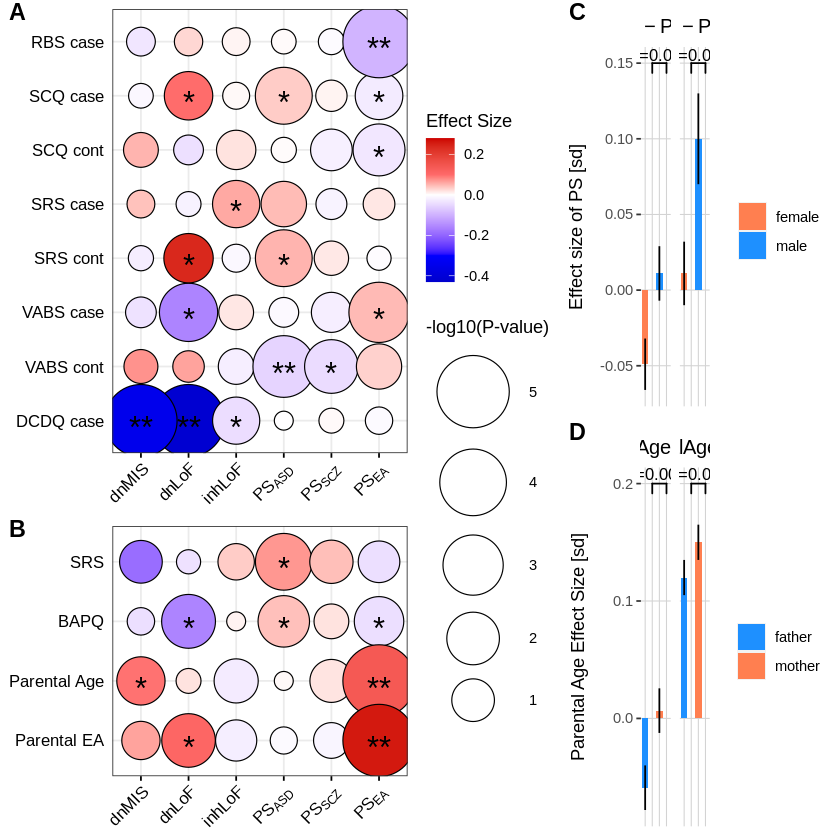

In [13]:
asd <- read.csv(file = 'clin_results_eur.SBayesR.20210709.csv', header = TRUE, na.string = "NA")

# Get significant sex interactions p-values and save them for later (for displaying in barplots)
controls_scq_combined_pssz = subset(x = asd,
    subset = case.status == "cont" & phenotype == "SCQ" & group == "combined" & variant.type == "ps.sz",)

controls_srs_combined_psasd = subset(x = asd,
    subset = case.status == "cont" & phenotype == "SRS" & group == "combined" & variant.type == "ps.asd",)

parent_pa_parents_inhlof = subset(x = asd,
    subset = case.status == "parent" & phenotype == "Parental Age" & group == "parents" & variant.type == "inhLoF",)

parent_pa_parents_psea = subset(x = asd,
    subset = case.status == "parent" & phenotype == "Parental Age" & group == "parents" & variant.type == "ps.ea",)

controls_scq_combined_pssz_sex_pval = toString(controls_scq_combined_pssz$sex.pval)
controls_srs_combined_psasd_sex_pval = toString(controls_srs_combined_psasd$sex.pval)
parent_pa_parents_inhlof_sex_pval = toString(parent_pa_parents_inhlof$sex.pval)
parent_pa_parents_psea_sex_pval = toString(parent_pa_parents_psea$sex.pval)



# Make p-value column ("logP.2" will used for scaling circles in figure)
asd$x.pval_log = -log10(asd$x.pval)
asd <- transform(asd, logP.2 = ifelse(x.pval_log >= 5, 5, x.pval_log))
# Concatenate the phenotype and case.status variables
asd$pheno = paste(asd$phenotype, "_", asd$case.status, sep="")

# 1) Create a column of significance labels for significant genotype effects
asd$stars <- cut(asd$x.pval, breaks=c(-Inf, 0.0007, 0.05, Inf), label=c("**", "*", ""))  # Create column of significance labels for main effect

# 2a) Filter data for panel A (cases & controls)
asd_cascon <- asd %>%
  filter(case.status %in% c("case", "cont")) %>%
  filter(group %in% c("combined")) %>%
  filter(variant.type %in% c( "dnmis", "dnlof", "inhLoF", "ps.asd", "ps.sz", "ps.ea"))

# 2b) Filter data for panel B (parents)
asd_parents <- asd %>%
  filter(group %in% c("parents")) %>%
  filter(variant.type %in% c( "dnmis", "dnlof", "inhLoF", "ps.asd", "ps.sz", "ps.ea"))

# 3a) Plot panel A = cases & controls
# Specify the factor levels in the order we want
asd_cascon$pheno <- factor(asd_cascon$pheno, levels = c("RBS_case", "SCQ_case", "SCQ_cont", "SRS_case", "SRS_cont", "VABS_case", "VABS_cont", "DCDQ_case"))
# Reverse the order as follow
asd_cascon$pheno <- factor(asd_cascon$pheno, levels = rev(levels(asd_cascon$pheno)))
asd_cascon$variant.type <- factor(asd_cascon$variant.type, levels = c("dnmis", "dnlof", "inhLoF", "ps.asd", "ps.sz", "ps.ea"))

# Make panel A
cascon_panelA <- ggballoonplot(asd_cascon, x = "variant.type", y = "pheno", size = "logP.2", size.range = c(5, 20), fill = "est", ggtheme = theme_bw()) +
                               scale_fill_gradientn(colors=c("blue3", "blue", "white", "indianred1", "red3"),
                                                    values=rescale(c(-0.43, -0.3, 0, 0.1, 0.28)),
                                                    limits=c(-0.43,0.28)) +
                               geom_text(aes(label=stars), color="black", vjust = 0.8, size=6.5) +
                               theme(axis.text.x = element_text(color = "black", size = 10, angle = 45),
                                     axis.text.y = element_text(color = "black", size = 10)) +
                               theme(axis.ticks.y = element_blank()) +
                               scale_size(range = c(5,20), breaks =c(1,2,3,4,5)) +
                               scale_y_discrete(breaks=c("RBS_case", "SCQ_case", "SCQ_cont", "SRS_case", "SRS_cont", "VABS_case", "VABS_cont", "DCDQ_case"),
                                                labels=c("RBS case", "SCQ case", "SCQ cont", "SRS case", "SRS cont", "VABS case", "VABS cont", "DCDQ case")) +
                               scale_x_discrete(breaks=c("dnmis", "dnlof", "inhLoF", "ps.asd", "ps.sz", "ps.ea"),
                                                labels=c("dnMIS", "dnLoF", "inhLoF", expression(PS[ASD]), expression(PS[SCZ]), expression(PS[EA]))) +
                               labs(size = "-log10(P-value)") +
                               labs(fill = "Effect Size")


# 3b) Plot panel B = parents
# Specify the factor levels in the order you want
asd_parents$pheno <- factor(asd_parents$pheno, levels = c("SRS_parent", "BAPQ_parent", "Parental Age_parent", "Parental EA_parent"))
# Reverse the order
asd_parents$pheno <- factor(asd_parents$pheno, levels = rev(levels(asd_parents$pheno)))
asd_parents$variant.type <- factor(asd_parents$variant.type, levels = c("dnmis", "dnlof", "inhLoF", "ps.asd", "ps.sz", "ps.ea"))

parents_panelB <- ggballoonplot(asd_parents, x = "variant.type", y = "pheno", size = "logP.2", size.range = c(5, 20), fill = "est", ggtheme = theme_bw()) +
                                scale_fill_gradientn(colors=c("blue3", "blue", "white", "indianred1", "red3"), values=rescale(c(-0.43, -0.3, 0, 0.1, 0.28)), limits=c(-0.43,0.28)) +
                                geom_text(aes(label=stars), color="black", vjust = 0.8, size=6.5) +
                                theme(axis.text.x = element_text(color = "black", size = 10, angle = 45),
                                      axis.text.y = element_text(color = "black", size = 10)) +
                                theme(axis.ticks.y = element_blank()) +
                                scale_size(range = c(5,20), breaks = c(1,2,3,4,5)) +
                                scale_y_discrete(breaks=c("SRS_parent", "BAPQ_parent", "Parental Age_parent", "Parental EA_parent"), 
                                                 labels=c("SRS", "BAPQ", "Parental Age", "Parental EA")) +
                                scale_x_discrete(breaks=c("dnmis", "dnlof", "inhLoF", "ps.asd", "ps.sz", "ps.ea"), 
                                                 labels=c("dnMIS", "dnLoF",  "inhLoF", expression(PS[ASD]),  expression(PS[SCZ]), expression(PS[EA]))) +
                                labs(size = "-log10(P-value)", labels = c("1", "2", "3", "4", "5")) +
                                labs(fill = "Effect Size [sd]")


# Panel C
asd_CD <- read.csv(file = 'clin_results_eur.SBayesR.20210709.csv', header = TRUE, na.string = "NA")

# 1) Create column of significance labels
asd_CD$stars.g <- cut(asd_CD$x.pval, breaks=c(-Inf, 0.0007, 0.05, Inf), label=c("**", "*", ""))  # Create column of significance labels for genotype effect
asd_CD$stars.g.sex <- cut(asd_CD$sex.pval, breaks=c(-Inf, 0.0007, 0.05, Inf), label=c("**", "*", ""))  # Create column of significance labels for genotype by sex effect

# 2a) Select data for panel C (controls for all g*sex interactions PS-SCZ with SCQ and VABS)
asd_C.1 <- asd_CD %>%
  filter(case.status %in% c("cont")) %>%
  filter(phenotype %in% c("SRS")) %>%
  filter(group %in% c("male", "female")) %>%
  filter(variant.type %in% c("ps.asd"))

asd_C.2 <- asd_CD %>%
  filter(case.status %in% c("cont")) %>%
  filter(phenotype %in% c("SCQ")) %>%
  filter(group %in% c("male", "female")) %>%
  filter(variant.type %in% c("ps.sz"))

asd_C <- rbind(asd_C.1, asd_C.2)

# 2b) Select data for panel D (Parental Age Effect size: inhLoF and PS-EA)
asd_D <- asd_CD %>%
  filter(phenotype %in% c("Parental Age")) %>%
  filter(group %in% c("mother", "father")) %>%
  filter(variant.type %in% c("inhLoF", "ps.ea"))

# 3.1) Make panel C (how do you get these p-values?)
pval_C_df <- data.frame(
  phenotype = c("SCQ", "SRS"),
  start = c("Female", "Female"),
  end = c("Male", "Male"),
  y.position = c(0.15, 0.15),
  pval = c(paste("P=",controls_scq_combined_pssz_sex_pval, sep=""), paste("P=",controls_srs_combined_psasd_sex_pval, sep=""))
)


# Labels for panel C
my_labellerC <- as_labeller(c(SCQ="SCQ - PS[SCZ]", SRS="SRS - PS[ASD]"), default = label_parsed) 


panelC <- ggplot(asd_C, aes(x=group, y=est, fill=group)) +
          geom_bar(stat="identity") +
          geom_linerange(aes(ymin=est-est.stderr, ymax=est+est.stderr), 
                         position=position_dodge(.9)) +
          scale_fill_manual(values=c("coral", "dodgerblue")) +
          labs(y = expression(paste("Effect size of PS [sd]"))) +
          geom_signif(
                  data = pval_C_df,
                  aes(xmin = start, xmax = end, annotations = pval, y_position = y.position),
                  textsize = 3.5, vjust = 0.1,
                  manual = TRUE, inherit.aes = FALSE) +
          theme(axis.title.x=element_blank(),
                axis.text.x=element_blank(),
                axis.ticks.x=element_blank(),
                panel.grid.major = element_line(size = 0.3, linetype = 'solid', colour = "lightgrey"),
                panel.background = element_blank(),
                legend.title = element_blank(),
                strip.background = element_rect(color="white", fill="white", size=1.5, linetype="solid"),
                strip.text.x = element_text(size = 12, color = "black")) +
          facet_wrap(~ phenotype, ncol = 2, labeller = my_labellerC) 


pval_D_df <- data.frame(
  variant.type = c("inhLoF", "ps.ea"),
  start = c("Father", "Father"),
  end = c("Mother", "Mother"),
  y.position = c(0.2, 0.2),
  pval = c(paste("P=",parent_pa_parents_inhlof_sex_pval, sep=""), paste("P=",parent_pa_parents_psea_sex_pval, sep=""))
)


# my_labellerD <- as_labeller(c(inhLoF="inhLoF[ ]", ps.ea="PS[EA]"), default = label_parsed) 
my_labellerD <- as_labeller(c(inhLoF="ParentalAge - inhLoF[ ]", ps.ea="ParentalAge - PS[EA]"), default = label_parsed)

panelD <- ggplot(asd_D, aes(x=group, y=est, fill=group)) +
          geom_bar(stat="identity") +
          geom_linerange(aes(ymin=est-est.stderr, ymax=est+est.stderr), 
                         position=position_dodge(.9)) +
          scale_fill_manual(values=c("dodgerblue", "coral")) +
          labs(y = "Parental Age Effect Size [sd]")+
          geom_signif(
              data = pval_D_df,
              aes(xmin = start, xmax = end, annotations = pval, y_position = y.position),
              textsize = 3.5,
              manual = TRUE, inherit.aes = FALSE) +
          theme(axis.title.x=element_blank(),
                axis.text.x=element_blank(),
                axis.ticks.x=element_blank(),
                panel.grid.major = element_line(size = 0.3, linetype = 'solid', colour = "lightgrey"),
                panel.background = element_blank(),
                legend.title = element_blank(),
                strip.background = element_rect(color="white", fill="white", size=1.5, linetype="solid"),
                strip.text.x = element_text(size = 12, color = "black")) +
          facet_wrap(~variant.type, ncol = 2, labeller = my_labellerD)



# Combine panels
panel_AB <- ggarrange(cascon_panelA, parents_panelB,
                      labels = c("A","B"),
                      nrow = 2,
                      ncol = 1,
                      align = "v",
                      widths = c(1, 1), heights = c(1.6, 1),
                      common.legend = TRUE, legend = "right",
                      font.label = list(size = 14, color = "black"),
                      vjust=1.2)

panel_CD <- ggarrange(panelC, panelD,
                      labels = c("C","D"),
                      nrow = 2,
                      ncol = 1,
                      align = "v",
                      common.legend = FALSE, legend = "right",
                      font.label = list(size = 14, color = "black"),
                      vjust=1.2)
                      
panel_AD <- ggarrange(panel_AB, panel_CD,
                      nrow = 1,
                      ncol = 2,
                      align = "v",
                      widths = c(2, 1), heights = c(1, 1),
                      common.legend = FALSE, legend = "bottom")
                      
panel_AD

# The plots will need to be postprocessed, they don't look very good as is.
ggsave("Figure_5.png", plot = panel_AD, width = 20, height = 20)




In [14]:
# Figure 4B

install.packages("corrplot2.tar.gz", repos = NULL)
install.packages("reshape2")
library(corrplot2)
library(reshape2)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’


corrplot2 0.1 loaded


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [15]:
options(stringsAsFactors = FALSE);
df = read.csv("asd_genetic_correlations_by_sex_final.SBayesR.20210729.tsv",sep="\t")

pal <- colorRampPalette(c("#000080","white","#b30000"))

get_mat <- function(df, name)
{
  mat <- acast(df, y~x, value.var=name, fill=NA)
  ord =  c("dnMIS","dnLOF","inhLoF",
           "pTDT.ASD.Dev","pTDT.SCZ.Dev","pTDT.EA.Dev",
           "RVRS","PRS");
  mat <- mat[ord,ord]
  
  # Labels
  labs = c("dnMIS","dnLoF","inhLoF",
           "ASD pTDT-dev","SCZ pTDT-dev","EA pTDT-dev",
           "Combined Rare",
           "PS Combined");

  colnames(mat)<-labs
  rownames(mat)<-labs
  return(mat)
}



n_pal <- 40
rows <- c("dnMIS","dnLoF","inhLoF","Combined Rare");
cols <- c("ASD pTDT-dev","SCZ pTDT-dev","EA pTDT-dev","PS Combined");

# Males
m_co <- get_mat(df,"male_cor")
m_pv <- get_mat(df,"male_pval")
f_co <- get_mat(df,"female_cor")
f_pv <- get_mat(df,"female_pval")

all_co <- get_mat(df,"combined_cor")
all_pv <- get_mat(df,"combined_pval")

m_co <- m_co[rows,cols]
f_co <- f_co[rows,cols]
all_co <- all_co[rows,cols]

m_pv <- m_pv[rows,cols]
f_pv <- f_pv[rows,cols]
all_pv <- all_pv[rows,cols]

# Rebrand female row names
row.names(f_co)<-c(1,2,3,4)
row.names(f_pv)<-c(1,2,3,4)
# rbind the matrices
sex_co <- rbind(m_co,f_co)
sex_pv <- rbind(m_pv,f_pv)
# Reorder rows
rows <- c("dnMIS",1,"dnLoF",2,"inhLoF",3,"Combined Rare",4);
sex_co<-sex_co[rows,]
sex_pv<-sex_pv[rows,]

dum<-rbind(1,0.75,0.5,0.25,0.1,0.049,0.0249,0.0099)
dum_cor <- matrix(min(m_co,f_co),nrow=length(dum),ncol=1)
row.names(dum_cor)<-c(1,0.75,0.5,0.25,0.1,0.05,0.025,0.01)
sig_lev <-  c(.01, .025, .05)


pdf("sex_genetic_corr_pval.pdf",width=12,height = 12)
corrplot2(
  cbind(dum_cor,sex_co),
  method="square",
  outline=TRUE,
  is.corr=FALSE,
  col=pal(n_pal),
  tl.col = "black",
  tl.srt = 30,
  tl.cex=1.5,
  p.mat=cbind(dum,sex_pv),
  insig = "label_sig",
  cl.pos = FALSE,
  sig.level = sig_lev,
  pch.cex = 5,
  pch.col = "white",
  norm_mat=dum,
  cl.lim=c(min(sex_co),max(sex_co)),
  cor_max = max(sex_co),
  cor_min = min(sex_co),
  win.asp = ncol(sex_co)/nrow(sex_co),
);

dev.off()

#############################

# Combined
pdf("combined_genetic_corr.pdf",width=12,height = 12)
corrplot2(
  all_co,
  method="square",
  outline=TRUE,
  is.corr=FALSE,
  col=pal(n_pal),
  tl.col = "black",
  tl.srt = 90,
  tl.cex = 1.5,
  p.mat=all_pv,
  sig.level =  sig_lev,
  insig = "label_sig",
  pch.cex = 5,
  pch.col = "white",
  norm_mat=dum,
  cl.lim=c(min(m_co,f_co),max(m_co,f_co)),
  cor_max = max(m_co,f_co),
  cor_min = min(m_co,f_co),

);
dev.off()
#############################
# Sex male + female

pdf("sex_genetic_corr.pdf",width=12,height = 12)
corrplot2(
  sex_co,
  method="square",
  outline=TRUE,
  is.corr=FALSE,
  col=pal(n_pal),
  tl.col = "black",
  tl.srt = 30,
  tl.cex = 1.5,
  p.mat=sex_pv,
  sig.level = sig_lev,
  insig = "label_sig",
  pch.cex = 5,
  pch.col = "white",
  norm_mat=dum,
  cl.lim=c(min(sex_co),max(sex_co)),
  cor_max = max(sex_co),
  cor_min = min(sex_co),
  win.asp = ncol(sex_co)/nrow(sex_co),

);
dev.off()




# Males
pdf("male_genetic_corr.pdf",width=12,height = 12)
corrplot2(
  m_co,
  method="square",
  outline=TRUE,
  is.corr=FALSE,
  col=pal(n_pal),
  tl.col = "black",
  tl.srt = 90,
  tl.cex = 1.5,
  p.mat=m_pv,
  sig.level =  c(.001, .01, .05),
  insig = "label_sig",
  pch.cex = 3,
  pch.col = "white",
  norm_mat=dum,
  cl.lim=c(min(m_co,f_co),max(m_co,f_co)),#c(-0.03,0.05),
  cor_max = max(m_co,f_co),
  cor_min = min(m_co,f_co),

);
dev.off()


# Females
pdf("female_genetic_corr.pdf",width=12,height = 12)
corrplot2(
  f_co,
  method="square",
  outline=TRUE,
  is.corr=FALSE,
  col=pal(n_pal),
  tl.col = "black",
  tl.srt = 90,
  tl.cex = 1.5,
  p.mat=f_pv,
  insig = "label_sig",
  pch.cex = 3,
  pch.col = "white",
  norm_mat=m_pv,
  sig.level = c(.001, .01, .05),
  cl.lim=c(min(m_co,f_co),max(m_co,f_co)),#c(-0.03,0.05),
  cor_max = max(m_co,f_co),
  cor_min = min(m_co,f_co),
);
dev.off()


png 
  2

png 
  2

png 
  2

png 
  2

png 
  2